<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Generate-Artificial-Data" data-toc-modified-id="Generate-Artificial-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generate Artificial Data</a></span></li><li><span><a href="#Fit-the-Model!" data-toc-modified-id="Fit-the-Model!-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fit the Model!</a></span></li><li><span><a href="#Emcee-Sampler-diagnostics" data-toc-modified-id="Emcee-Sampler-diagnostics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Emcee Sampler diagnostics</a></span></li><li><span><a href="#More-diagnostics" data-toc-modified-id="More-diagnostics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>More diagnostics</a></span></li></ul></div>

In [1]:
%matplotlib inline

from gEcon.classes.model import gEconModel
from gEcon.plotting import plotting as gp
import matplotlib.pyplot as plt
import numpy as np

import arviz as az

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

In [2]:
import statsmodels.api as sm

In [3]:
file_path = 'GCN Files/RBC_complete.gcn'
model = gEconModel(file_path)

Model Building Complete.
Found:
	10 equations
	10 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	2 stochastic shocks
		 2 / 2 has a defined prior. 
	7 parameters
		 5 / 7 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Generate Artificial Data

Steady state found! Sum of squared residuals is 5.17689969051289e-30
Solution found, sum of squared residuals:  2.6076248898809e-31
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


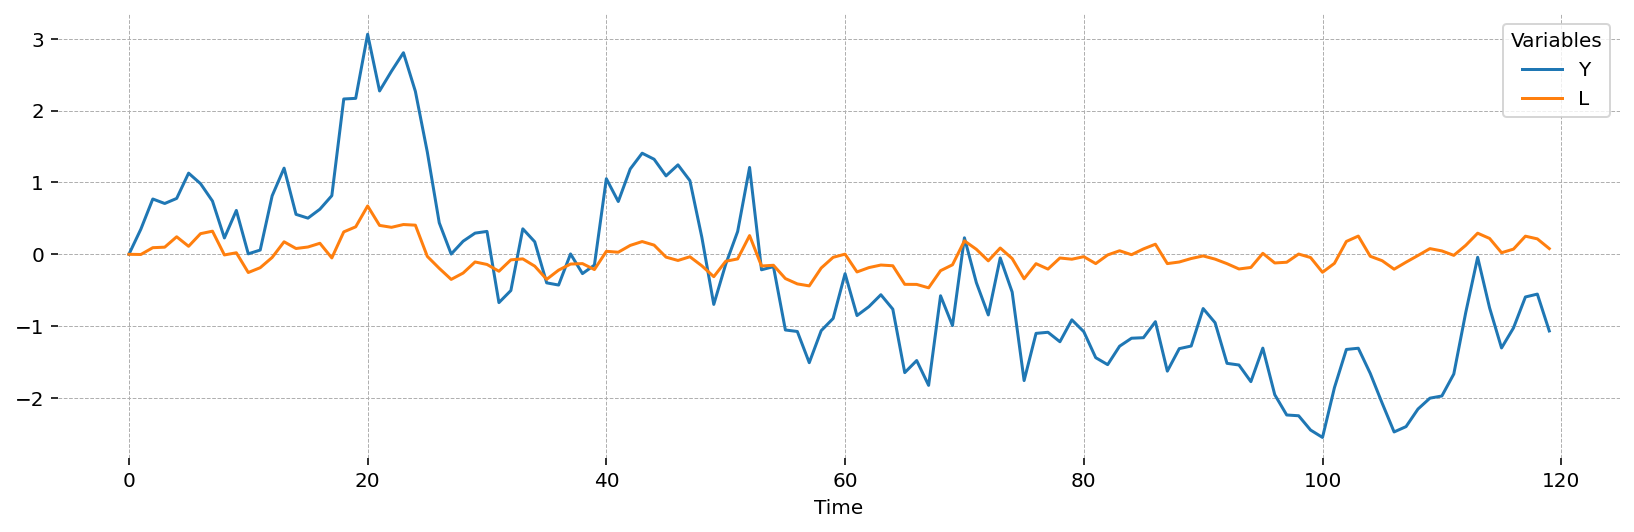

In [4]:
observed_vars = ['Y', 'L']

true_params = {'sigma_C':1.35, 'sigma_L':2.73, 'alpha':0.287, 'rho_A':0.87, 'rho_B':0.52}
true_shocks = {'epsilon_A':0.22, 'epsilon_B':0.09}

model.free_param_dict.update(true_params)
model.steady_state()
model.solve_model()

true_params.update(true_shocks)

Sigma = np.array([[true_shocks['epsilon_A'], 0.0],
                  [0.0, true_shocks['epsilon_B']]])

fake_data_all = model.simulate(simulation_length=120, n_simulations=1, shock_cov_matrix=Sigma).T.droplevel(1)
fake_data = fake_data_all[observed_vars].copy()

fake_data.plot();

## Fit the Model!

In [5]:
idata = model.fit(fake_data, filter_type='univariate', draws=10_000, n_walkers = 36, return_inferencedata=True, burn_in=1000)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [15:59<00:00, 10.42it/s]
C:\Users\Jesse\miniconda3\envs\econ\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


## Emcee Sampler diagnostics

[Foreman-Mackey et al. (2014)](https://arxiv.org/abs/1202.3665), the authors of `emcee`, advocate two diagnostics to check that sampling has been successful: acceptance ratio and autocorrelation decay time. We can check both of these in the sampler object.

They suggest that an acceptance ratio between 0.2-0.6 is good, while autocorrelation decay should just be as low as possible. The important thing with autocorrelation is to make sure we get at least 100 independent samples. `emcee` will automatically show a warning after you call `model.fit()` if you did not get at least this many samples.

Acceptance fractions look good!

In [6]:
idata.sample_stats.acceptance_fraction

<xarray.DataArray 'acceptance_fraction' (chain: 36)>
array([0.4377, 0.4504, 0.4513, 0.4458, 0.4507, 0.4394, 0.4391, 0.4508,
       0.4486, 0.4449, 0.4534, 0.4401, 0.4444, 0.4387, 0.4522, 0.4394,
       0.43  , 0.4484, 0.4357, 0.448 , 0.4328, 0.4451, 0.451 , 0.4421,
       0.4369, 0.4435, 0.4483, 0.4419, 0.4469, 0.4402, 0.4449, 0.4415,
       0.4504, 0.4481, 0.4377, 0.4508])
Coordinates:
  * chain    (chain) int32 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35

We can see the sampler struggled with the standard error on `epsilon_B`, the household preference shock. 

In [7]:
idata.sample_stats.autocorrelation_time

<xarray.DataArray 'autocorrelation_time' (parameters: 7)>
array([ 46.21139328,  41.79074765,  60.04568357,  53.36914756,
        66.58042704,  44.82842396, 100.76157335])
Coordinates:
  * parameters  (parameters) <U11 'sigma_C' 'sigma_L' ... 'epsilon_B_t'

## More diagnostics

In addition to the Emcee diagnostics, we can run additional checks using the `Arviz` package. First we will convert the sampler to an arviz `idata` object, giving names to the variables.

The r-hat is a common measure of chain mixing. If all the chains from our sampler converge to the same distribution, the r-hat statistic is 1.0. The higher it is, the worse the chains "mix", suggesting that the sampler failed to converge on a single distribution. We don't want to see anything above 1.05. Here our chains look OK.

In [8]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_C,1.174,0.067,1.052,1.304,0.001,0.001,6813.0,13032.0,1.00
sigma_L,1.297,0.082,1.139,1.449,0.001,0.001,7407.0,14280.0,1.01
alpha,0.184,0.058,0.085,0.293,0.001,0.001,5000.0,8386.0,1.01
rho_A,0.967,0.011,0.947,0.985,0.000,0.000,5798.0,8861.0,1.00
rho_B,0.791,0.065,0.675,0.910,0.001,0.001,4098.0,3691.0,1.01
epsilon_A_t,0.183,0.021,0.145,0.222,0.000,0.000,7058.0,11170.0,1.01
epsilon_B_t,0.052,0.019,0.025,0.086,0.000,0.000,3977.0,2106.0,1.01


The best check is always visual. We can see that things mostly converged, but there is a lot of noise in the chains. The bad chains in Epsilon B are visible, as are some chains for alpha and rho_A that got stuck.

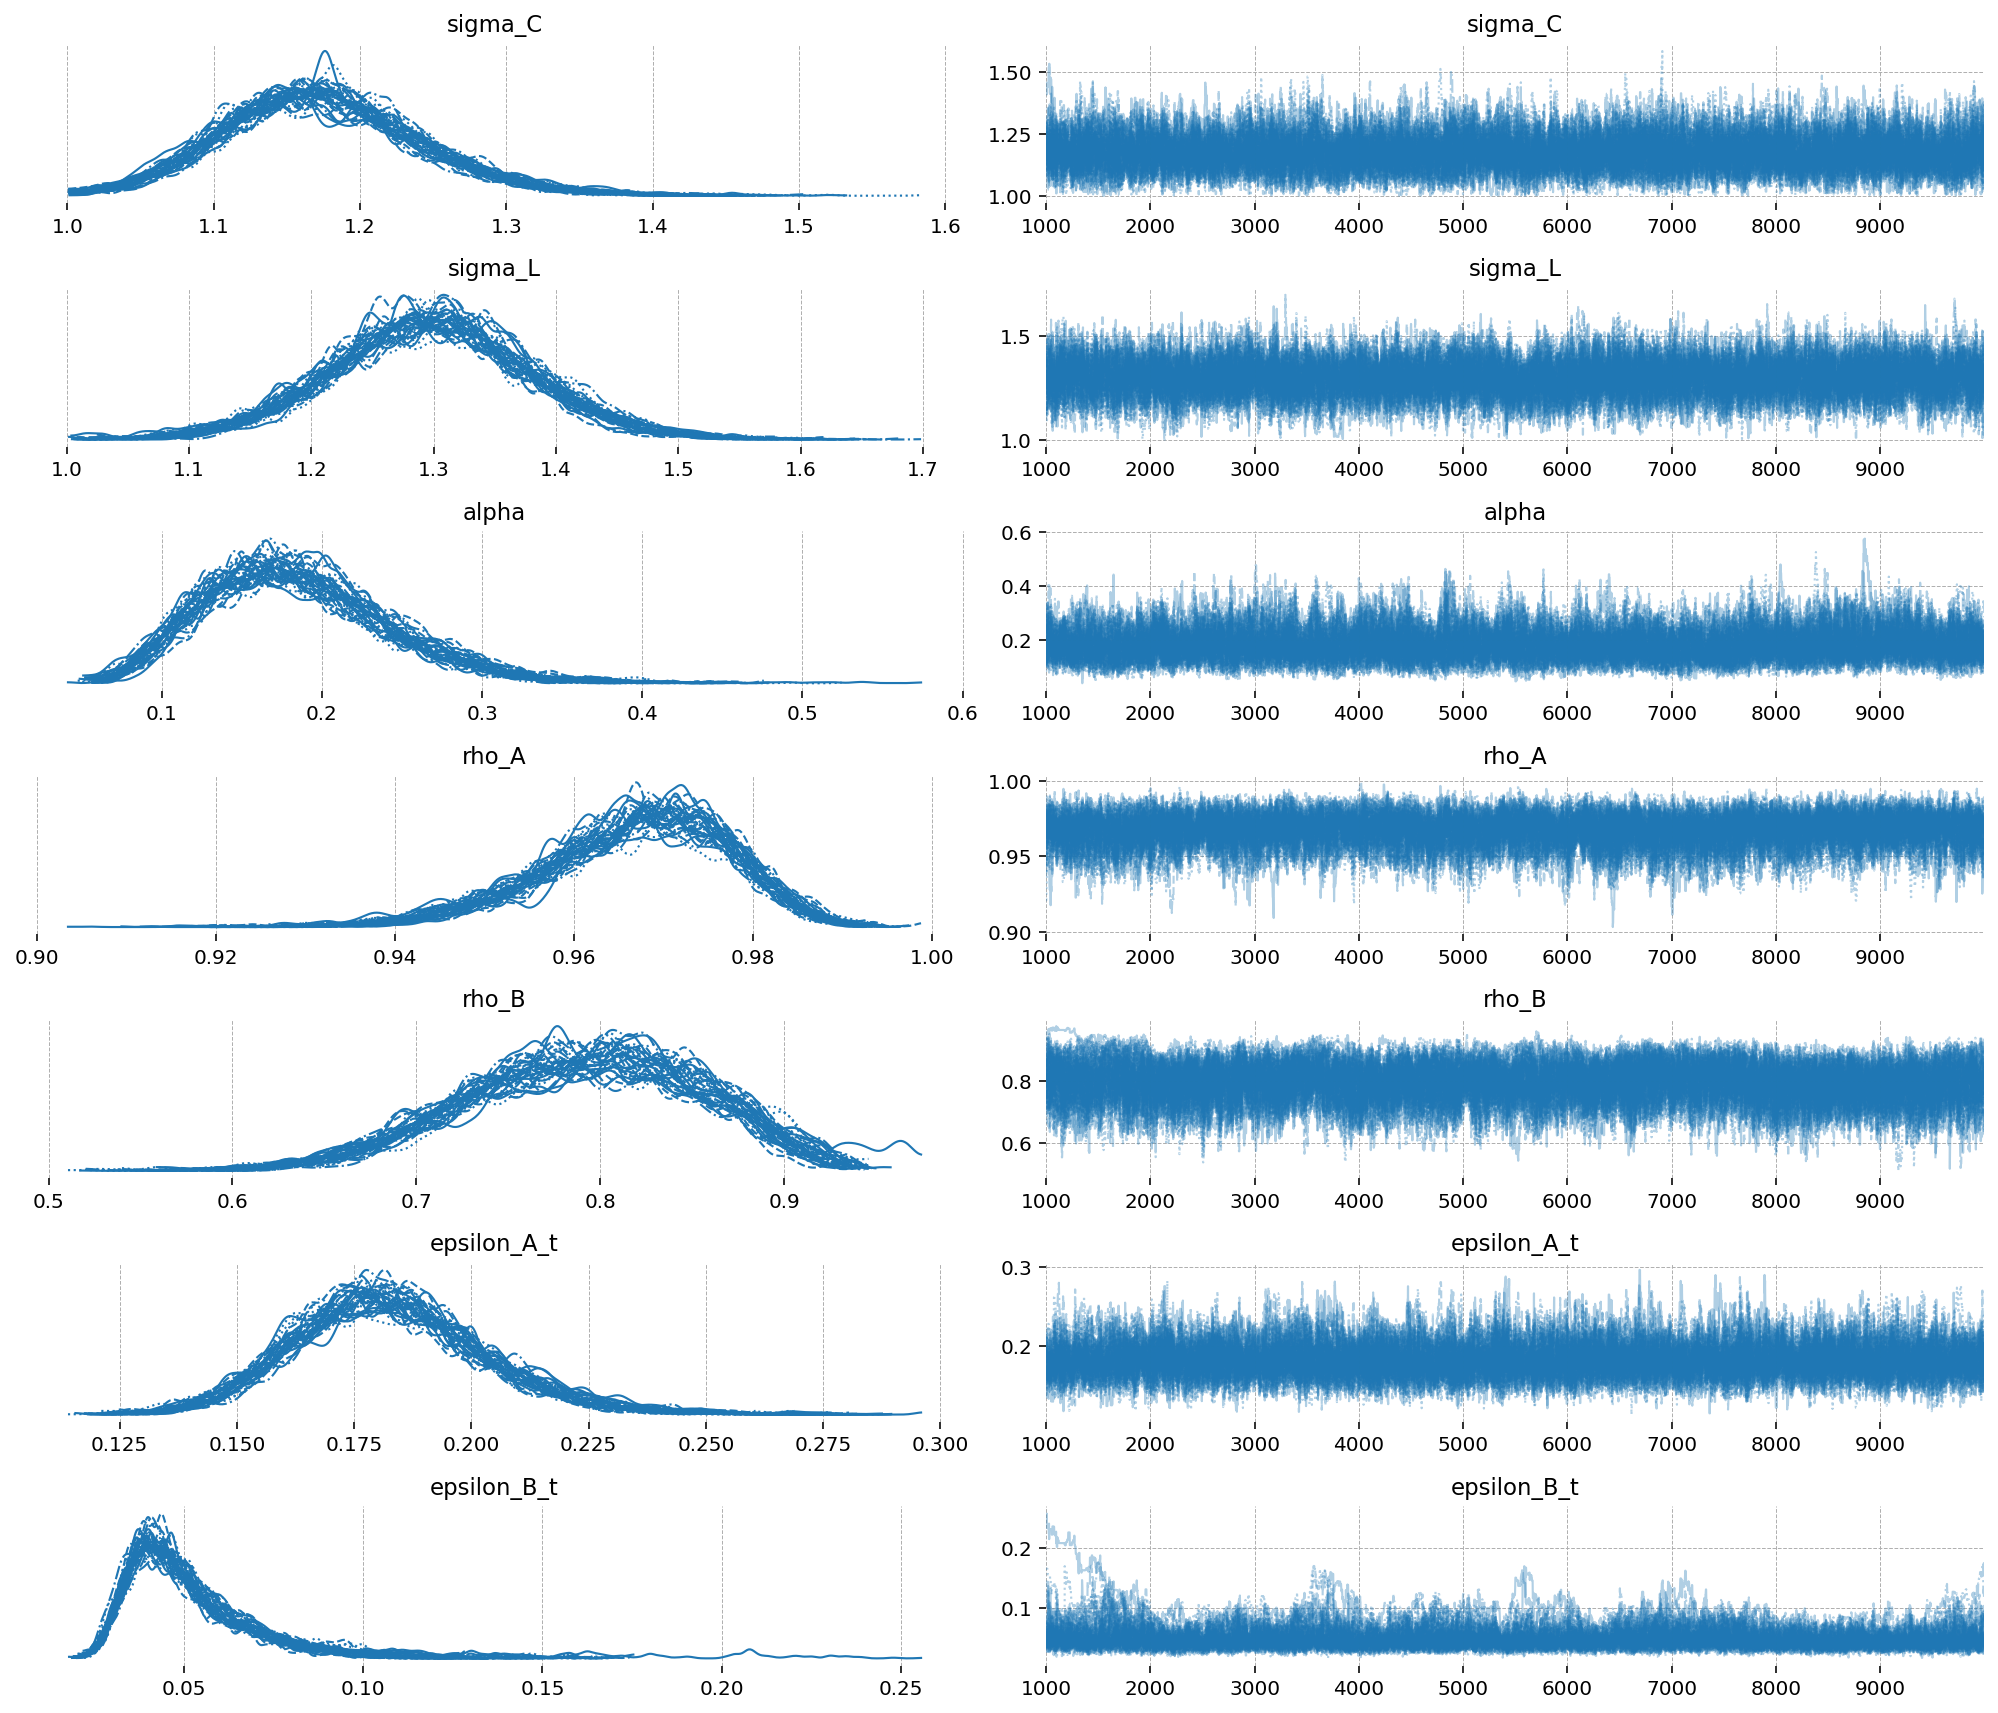

In [9]:
fig, ax = plt.subplots(7, 2, figsize=(14,12), dpi=144)
az.plot_trace(idata.sel(draw=slice(1000, None)), axes=ax)
fig.tight_layout()
plt.show()

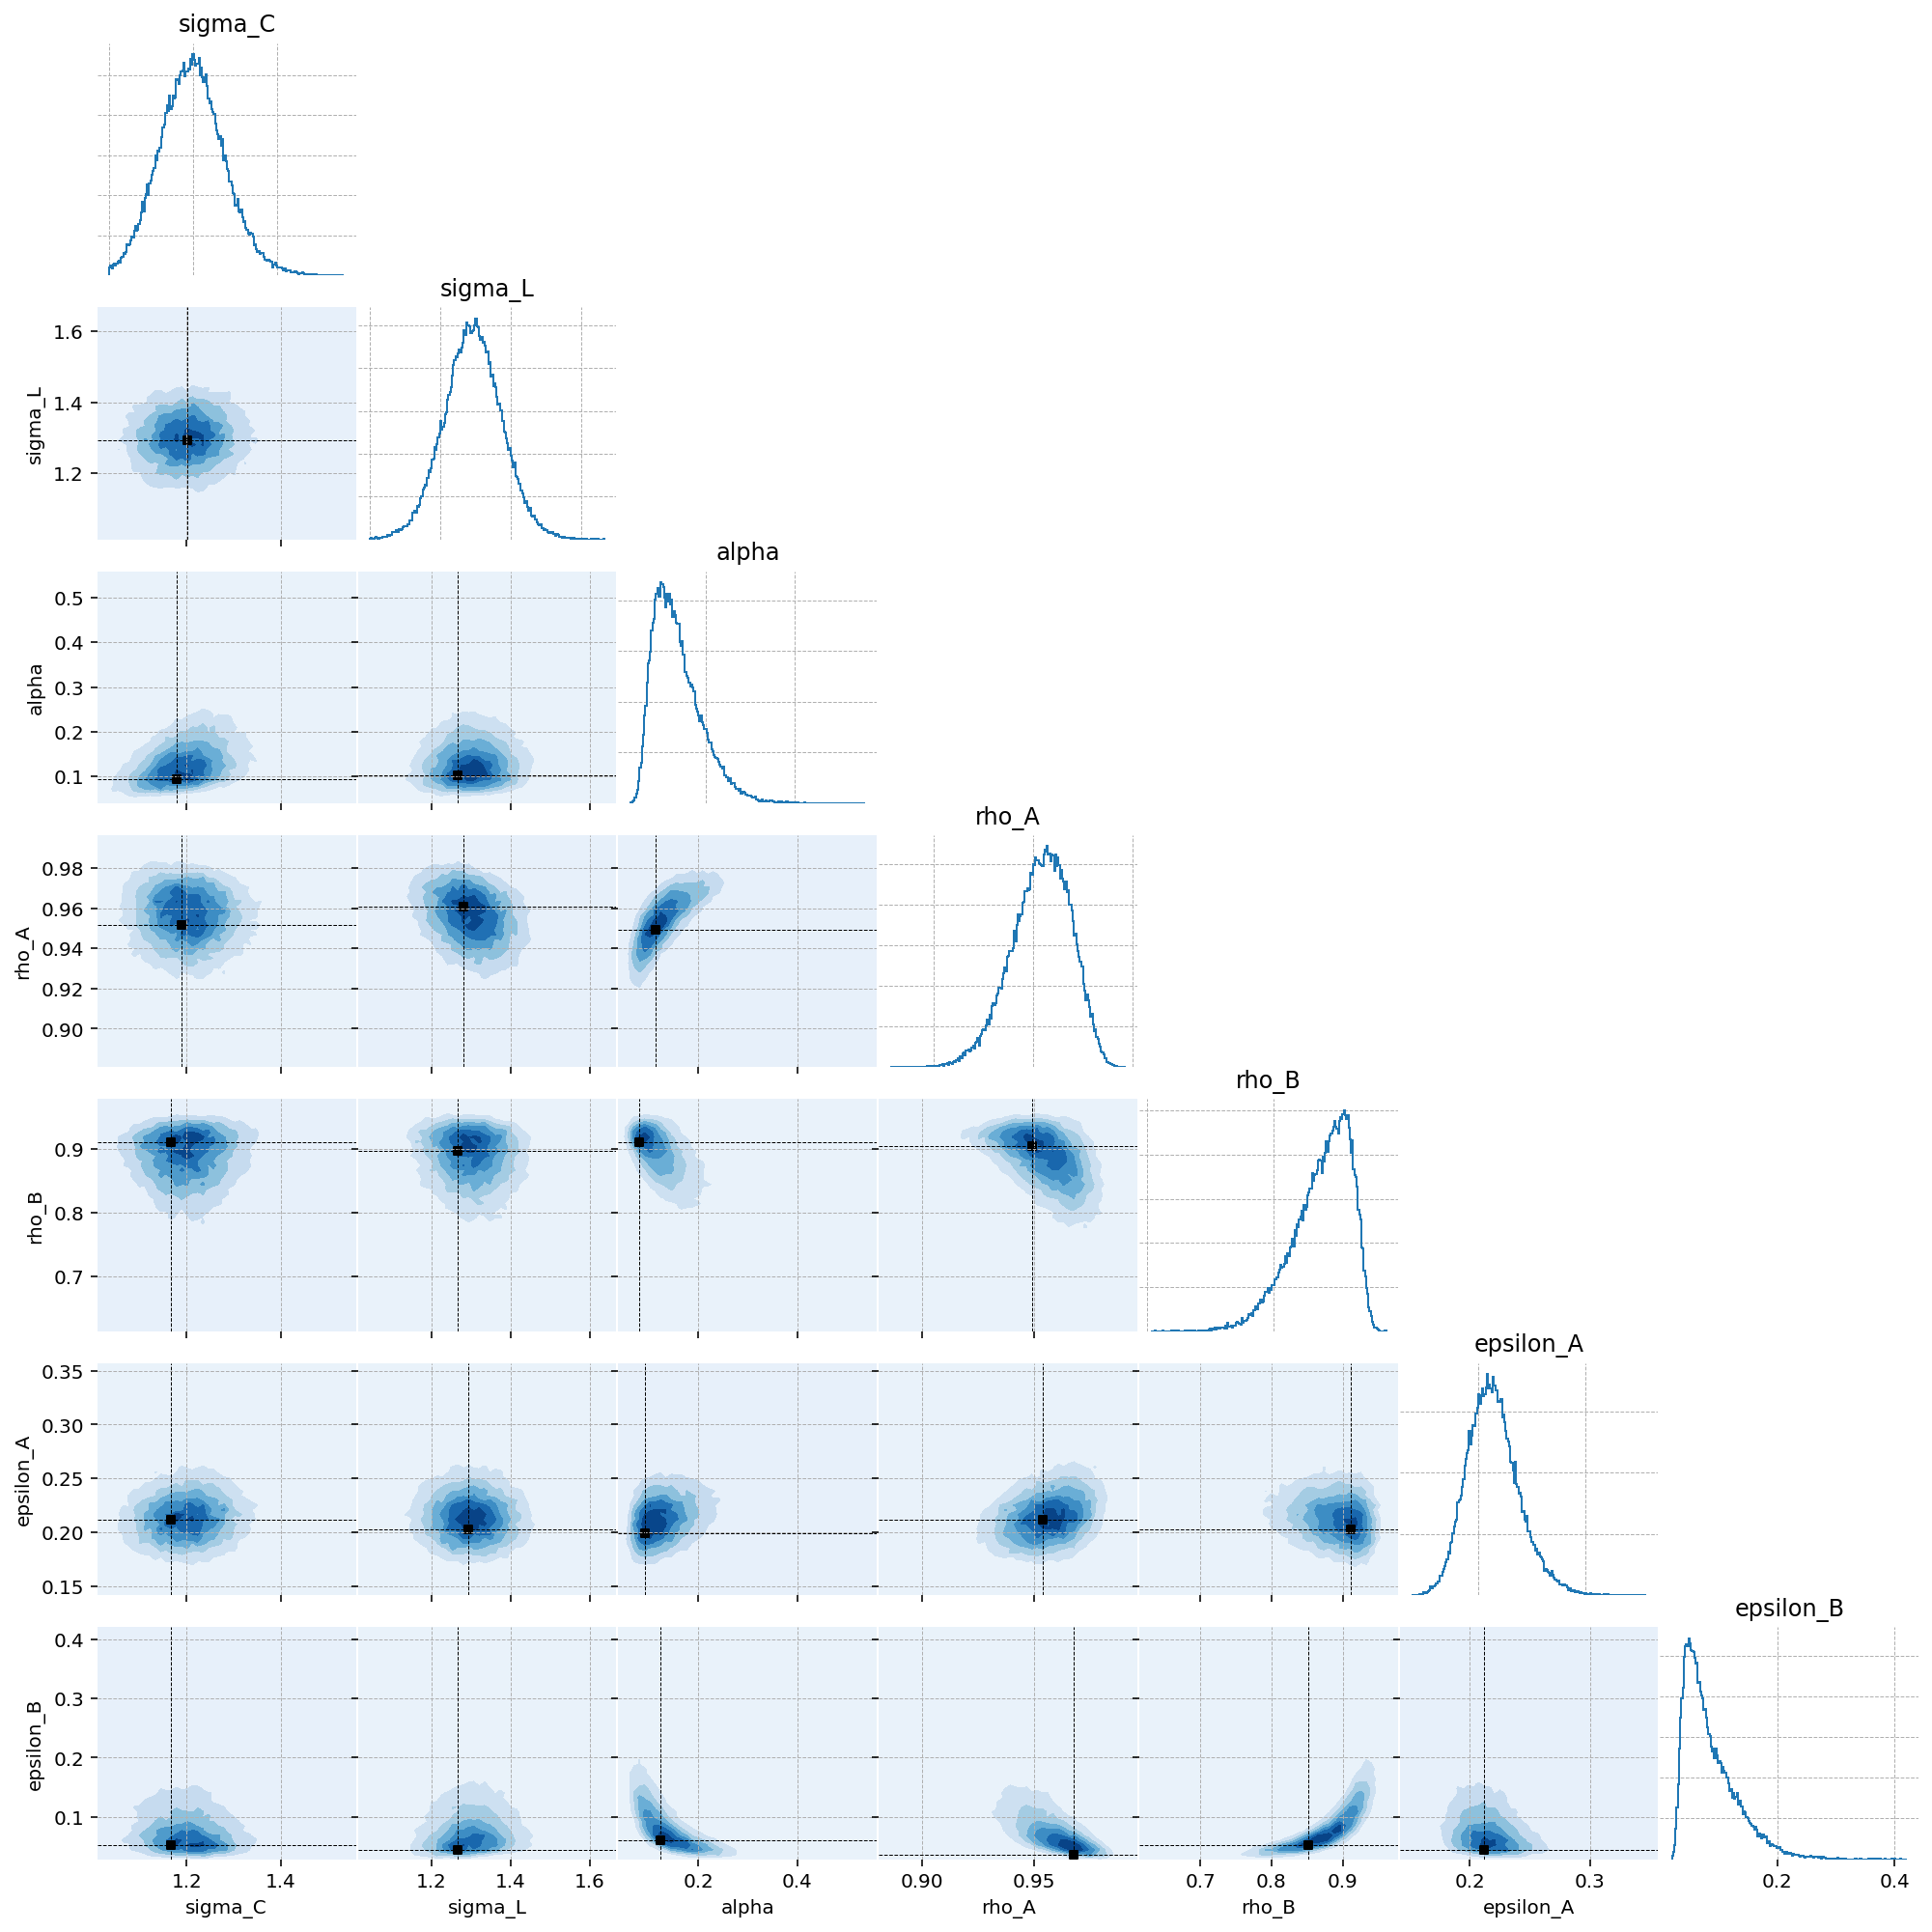

In [10]:
gp.plot_corner(idata.sel(draw=slice(1000, None)))

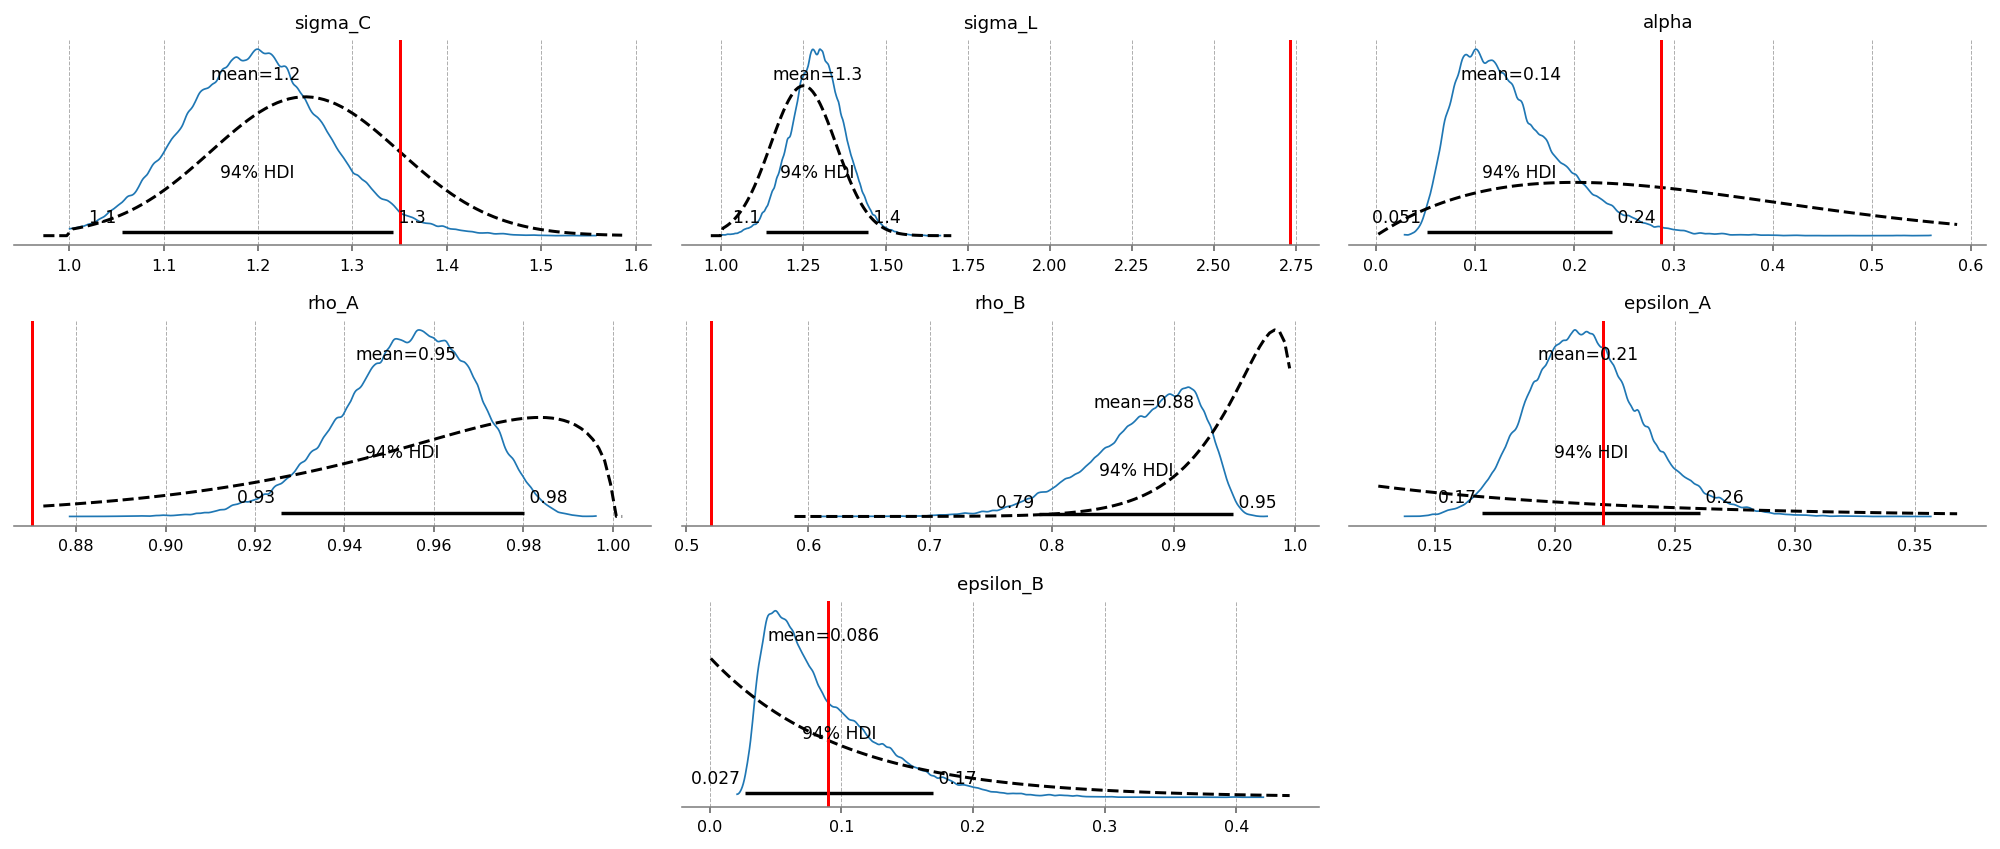

In [11]:
from gEcon.estimation.estimation_utilities import extract_prior_dict

prior_dict = extract_prior_dict(model)
true_params.update(true_shocks)

fig = plt.figure(figsize=(14,6))
gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=7)

for loc in plot_locs:
    axis = fig.add_subplot(gs[loc])
    
axes = az.plot_posterior(idata, figsize=(14,6), textsize=8, ax=fig.axes)
for i, axis in enumerate(axes):
    xlim = axis.get_xlim()
    x_grid = np.linspace(*xlim, 100)
    param = axis.get_title()
    axis.plot(x_grid, prior_dict[param].pdf(x_grid), c='k', ls='--')
    axis.axvline(true_params[param], c='r')
fig.tight_layout()

In [16]:
import sympy
from aesara.tensor.var import TensorVariable
from sympy.printing.aesaracode import aesara_code, aesara_function

t = sympy.Symbol('t')
sympy_expr = t**2
aef = aesara_function([t], [sympy_expr])


def input(time):
    if isinstance(time, TensorVariable):
        return aesara_code(sympy_expr)
    else:
        return aef(time)


def freefall(y, t, p):
    return 2.0 * p[1] - p[0] * y[0] + aef(t)

In [15]:
aef(5)

array(25.)